In [64]:
#load the embeddings
import pickle
import numpy as np
from sklearn import metrics
import operator
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import pandas as pd

with open('embeddings/data.pkl', 'rb') as f:
    data = pickle.load(f)

words = data['w']
embeddings = data['E']

In [65]:
def cosine_sim(v1, v2):
    return metrics.pairwise.cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))[0][0]

In [81]:
def cosine_distance_func(v1, v2):
    return 1 - cosine_sim(v1, v2)

In [66]:
embeddings = np.asarray(embeddings)
embeddings.shape
sf_embeddings = np.zeros((2000, 2, 300))

for i in range(2000):
    sf_embeddings[i, 0, :] = embeddings[i, 0, :]
    sf_embeddings[i, 1, :] = embeddings[i, -1, :]


In [67]:
#cosine distances
cosine_dists = []
for i, start_final_embed in enumerate(sf_embeddings):
    cs = 1 - cosine_sim(start_final_embed[0], start_final_embed[1])
    cosine_dists.append((words[i], cs))

cosine_dists = sorted(cosine_dists, key=operator.itemgetter(1), reverse=True)

most_change = cosine_dists[:20]
least_change = cosine_dists[-20:]

print(most_change)
print(least_change)

cosine_reorder = np.zeros((2000, 3000))

for i, (word, score) in enumerate(cosine_dists):
    cosine_reorder[i] = np.asarray(embeddings[words.index(word)]).reshape(3000)

[('techniques', 1.0), ('skills', 1.0), ('mcgraw', 1.0), ('ml', 1.0), ('programs', 0.9908060408371938), ('objectives', 0.9777930257849913), ('computer', 0.9612410643483436), ('radio', 0.9052701147159458), ('sector', 0.9006836366602485), ('goals', 0.8451478071876328), ('approach', 0.8398605922816098), ('van', 0.8367483908002056), ('shri', 0.8244319851175983), ('media', 0.8125349168703302), ('impact', 0.8000341939038889), ('perspective', 0.7931199949661136), ('patterns', 0.7823269040416171), ('berkeley', 0.7779084933889082), ('shift', 0.776931638140915), ('film', 0.775918934819861)]
[('miles', 0.3257129148141351), ('payment', 0.3227135807934537), ('door', 0.3222822738775527), ('evening', 0.32186251996765325), ('week', 0.31992764436258925), ('feet', 0.31866460292824705), ('september', 0.31786901281959445), ('god', 0.315084508297378), ('december', 0.31373757998712093), ('daughter', 0.311677059890762), ('months', 0.30972055852261215), ('century', 0.30730617145950123), ('january', 0.301795550

In [85]:
def local_neighbourhood_dist(v1, v2, neighbours, flattened_embeddings):
    start_distances, start_indexes = neighbours.kneighbors(v1.reshape(1, -1))
    final_distances, final_indexes = neighbours.kneighbors(v2.reshape(1, -1))

    union_indexes = np.union1d(start_indexes, final_indexes)

    start_cos_sim = []
    final_cos_sim = []

    for uidx in union_indexes:
        start_cos_sim.append(cosine_sim(v1, flattened_embeddings[uidx]))
        final_cos_sim.append(cosine_sim(v2, flattened_embeddings[uidx]))


    local_neighbourhood = 1 - cosine_sim(np.asarray(start_cos_sim), np.asarray(final_cos_sim))
    
    return local_neighbourhood


In [86]:
# local neighbourhood distance
flattened_embeddings = embeddings.reshape(-1, embeddings.shape[-1])
k = 8

neighbours = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute').fit(flattened_embeddings)
local_neighbourhood_dists = []
for i, start_final_embed in enumerate(sf_embeddings):
    lnd = local_neighbourhood_dist(start_final_embed[0], start_final_embed[1], neighbours, flattened_embeddings)
    local_neighbourhood_dists.append((words[i], lnd))
    
local_neighbourhood_dists = sorted(local_neighbourhood_dists, key=operator.itemgetter(1), reverse=True)

most_change = local_neighbourhood_dists[:20]
least_change = local_neighbourhood_dists[-20:]

print(most_change)
print(least_change)

lnd_reorder = np.zeros((2000, 3000))

for i, (word, score) in enumerate(local_neighbourhood_dists):
    lnd_reorder[i] = np.asarray(embeddings[words.index(word)]).reshape(3000)

[('techniques', 1.0), ('skills', 1.0), ('mcgraw', 1.0), ('ml', 1.0), ('objectives', 0.9413197713847011), ('computer', 0.8959350693151715), ('programs', 0.8608415206215172), ('radio', 0.6738930578524192), ('sector', 0.6626955971850855), ('goals', 0.48456887754237843), ('approach', 0.44565019282953944), ('impact', 0.4211100020056966), ('patterns', 0.41774150548750544), ('media', 0.4145756213620895), ('van', 0.3978071646773619), ('assessment', 0.3954462168768038), ('shri', 0.3838737925671062), ('perspective', 0.3620905759443538), ('film', 0.35486744846132945), ('berkeley', 0.34825792582467496)]
[('wife', 0.022937520233537345), ('door', 0.022864107747942675), ('december', 0.02282824877104883), ('miles', 0.022690694989198956), ('october', 0.022682100275372763), ('coast', 0.02259643285059465), ('church', 0.022255000210929632), ('months', 0.022029446057825197), ('february', 0.021841085662237747), ('january', 0.021540523644693277), ('daughter', 0.020648232529298705), ('god', 0.0199991841157454

In [70]:
def normalize(a):
	a_oo = a - np.real(a).min()
	return a_oo/np.abs(a_oo).max()


In [71]:
def euclidean_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

In [72]:
# Eucliedean distance

euclidean_dists = []
eucli_scores = []
for start_final_embed in sf_embeddings:
    ed = euclidean_dist(start_final_embed[0], start_final_embed[1])
    eucli_scores.append(ed)

normalized_eucli_scores = normalize(eucli_scores)

for i, score in enumerate(normalized_eucli_scores):
    euclidean_dists.append((words[i], score))

euclidean_dists = sorted(euclidean_dists, key=operator.itemgetter(1), reverse=True)

most_change = euclidean_dists[:20]
least_change = euclidean_dists[-20:]

print(most_change)
print(least_change)

eucli_reorder = np.zeros((2000, 3000))

for i, (word, score) in enumerate(euclidean_dists):
    eucli_reorder[i] = np.asarray(embeddings[words.index(word)]).reshape(3000)

[('programs', 1.0), ('objectives', 0.9871510890202615), ('computer', 0.9706836769649055), ('radio', 0.9139212621475846), ('sector', 0.9091931147030355), ('goals', 0.8509570909131131), ('approach', 0.8453143369289917), ('van', 0.8419845484128958), ('shri', 0.8287459128462534), ('media', 0.8158637873836437), ('impact', 0.8022260011674353), ('perspective', 0.7946371044536107), ('patterns', 0.7827243784729944), ('berkeley', 0.7778239268895575), ('shift', 0.7767386213541857), ('film', 0.7756127673484814), ('assessment', 0.7669141337216147), ('stanford', 0.7662011512401127), ('challenge', 0.7650971566362096), ('therapy', 0.7587435636826948)]
[('miles', 0.16796571480805406), ('payment', 0.16280558921256819), ('door', 0.16206158972244267), ('evening', 0.16133704086478823), ('week', 0.15799107375739052), ('feet', 0.15580144422084483), ('september', 0.15441996791298945), ('god', 0.14957124103663047), ('december', 0.14721811337362947), ('daughter', 0.14360852170418287), ('months', 0.1401700887913

In [73]:
pearson_mat = np.zeros((3, 3))
reorders = [cosine_reorder, lnd_reorder, eucli_reorder]

for i in range(3):
    for j in range(3):
        pearson_mat[i, j] = pearsonr(reorders[i].reshape(6000000), reorders[j].reshape(6000000))[0]
    
pearson_mat

array([[1.        , 0.02831613, 0.5722136 ],
       [0.02831613, 1.        , 0.02433646],
       [0.5722136 , 0.02433646, 1.        ]])

In [74]:
# get average of the words that have changed the most from papers and get the average
changed_words = set(['recording', 'gay', 'tape', 'checking', 'diet', 'sex', 'bitch', 'plastic', 'transmitted', 'hug', 'windows', 'bush', 'apple', 'sink', 'click', 'handle', 'fatal', 'awful', 'nice', 'broadcast', 'monitor', 'record', 'guy', 'call'
,'wanting', 'check', 'starting', 'major', 'actually', 'touching', 'harry', 'headed', 'romance', 'know', 'got', 'would', 'decided', 'think', 'stop', 'remember', 'started', 'must', 'wanted', 
'harry', 'headed', 'calls', 'gay', 'wherever', 'male', 'actually', 'special', 'cover', 'naturally', 'peck', 'honey'])

words_found = []
for w in changed_words:
    if w in words:
        words_found.append(w)

distance_metrics = [cosine_dists, local_neighbourhood_dists, euclidean_dists]

scores = []
for distance_metric in distance_metrics:
    score = []
    for word_tuple in distance_metric:
        for top_word in words_found:
            if top_word == word_tuple[0]:
                score.append(word_tuple[1])
    scores.append(sum(score) / len(score))

distance_metrics_texts = ['cosine', 'local_neighbourhood_dist', 'euclidean_dist']
for i in range(3):
    print(f"average scores for {distance_metrics_texts[i]}: {scores[i]}")

average scores for cosine: 0.5285829030261675
average scores for local_neighbourhood_dist: 0.08709592835416816
average scores for euclidean_dist: 0.4736040542331469


In [75]:
def min_max_scale(sim_score):
    return (sim_score - 1) / 3

def parse_row(row):
    dict = {}
    dict["word"] = row["lemma"].strip().lower()
    dict["start"] = int(row["time_b"][2])
    dict["end"] = int(row["time_a"][2])

    sim_scores = row["sim_score"].split('\n')
    sim_scores = [int(x) for x in sim_scores]
    avg_sim_scores = sum(sim_scores) / len(sim_scores)
    dict["avg_sim_score"] = min_max_scale(avg_sim_scores)

    return dict
    

In [76]:
df = pd.read_csv('DUPS/aggregate.csv')

index_arr = []
avg_distance_arr = []
new_word_set = set()

for index, row in df.iterrows():
    parsed = parse_row(row)
    if parsed['word'] in words:
        if parsed['word'] not in new_word_set:
            new_word_set.add(parsed['word'])
        index_arr.append((words.index(parsed['word']), parsed['start'], parsed['end']))
        avg_distance_arr.append(1 - float( parsed['avg_sim_score']))


print(f"new words found: {new_word_set}")

new words found: {'mirror', 'card', 'signal', 'energy', 'sphere'}


In [87]:
dist_funcs = [cosine_distance_func, local_neighbourhood_dist, euclidean_dist]
dist_arrs = [[], [], []]

for (index, start, end) in index_arr:
    start_vec, end_vec = embeddings[index, start], embeddings[index, end]

    for i, func in enumerate(dist_funcs):
        if i == 1:
            dist_arrs[i].append(func(start_vec, end_vec, neighbours, flattened_embeddings))
        else:
            dist_arrs[i].append(func(start_vec, end_vec))

In [91]:
distance_metrics_texts = ['cosine_dist', 'local_neighbourhood_dist', 'euclidean_dist']

for i, arr in enumerate(dist_arrs):
    pearson = pearsonr(arr, avg_distance_arr)
    print(f"pearson stats for {distance_metrics_texts[i]}: {pearson[0]}")

pearson stats for cosine_dist: -0.004801047741891668
pearson stats for local_neighbourhood_dist: 0.015169106676668346
pearson stats for euclidean_dist: -0.006921076690807385


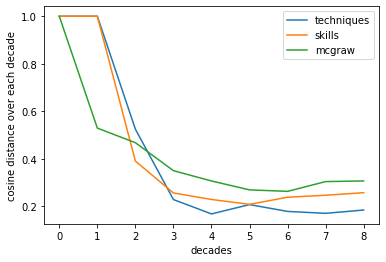

In [90]:
# best measure is probably cosine distance

import matplotlib.pyplot as plt

best_words = ['techniques', 'skills', 'mcgraw']

cosine_dists = np.zeros((3, 9))

for i, word in enumerate(best_words):
    idx = words.index(word)
    embed = embeddings[idx]

    for j in range(9):
        cosine_dists[i, j] = 1 - cosine_sim(embed[j], embed[j+1])

plt.figure()

for i in range(3):
    plt.plot(np.arange(9), cosine_dists[i], label=best_words[i])

plt.xlabel("decades")
plt.ylabel("cosine distance over each decade")

plt.legend()
plt.savefig("cs_decades")
plt.show()

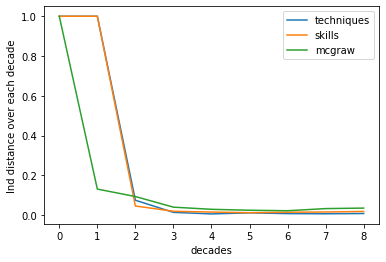

In [92]:
best_words = ['techniques', 'skills', 'mcgraw']

lnd_dists = np.zeros((3, 9))

for i, word in enumerate(best_words):
    idx = words.index(word)
    embed = embeddings[idx]

    for j in range(9):
        lnd_dists[i, j] = local_neighbourhood_dist(embed[j], embed[j+1], neighbours, flattened_embeddings)

plt.figure()

for i in range(3):
    plt.plot(np.arange(9), lnd_dists[i], label=best_words[i])

plt.xlabel("decades")
plt.ylabel("lnd distance over each decade")

plt.legend()
plt.savefig("lnd_decades")
plt.show()